### Necessary Packages

In [1]:
import torch
import sys
import dotenv
import os
import torch
import matplotlib.pyplot as plt
sys.path.append('../../..')
from src.models import MultiBranchAttention
from torch.utils.data import DataLoader
from torchvision.transforms import Lambda
from src.utils import load_model_from_folder,load_history_from_folder
from src.datasets import TensorDataset
from tqdm.notebook import tqdm
from torchmetrics import F1Score,Accuracy,AUROC,Metric,Precision,Recall

Key OPENSLIDE_PATH not found in /home/abdelnour/Documents/4eme_anne/S2/project_2sc/repo/.env.
Key OPENSLIDE_PATH not found in /home/abdelnour/Documents/4eme_anne/S2/project_2sc/repo/.env.


### Setup the code to be device agnostic

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.type)

cuda


### Results reproducibility

In [3]:
torch.manual_seed(0)

### Loading envirement variables

In [4]:
TENSORS_DIR = dotenv.get_key(dotenv.find_dotenv(), "ATT2_RESNET18_TENSORS_DIR")
MODELS_DIR = dotenv.get_key(dotenv.find_dotenv(), "ATT2_RESNET18_LRDECAY_MODELS_DIR")
HISTORIES_DIR = dotenv.get_key(dotenv.find_dotenv(), "ATT2_RESNET18_LRDECAY_HISTORIES_DIR")

In [5]:
TEST_DIR = os.path.join(TENSORS_DIR, "test")

### Global

In [6]:
BATCH_SIZE = 1
NUM_WORKERS = 0
PREFETCH_FACTOR = None

In [7]:
d_features = 512
d_inner = 256
mask_rate = 0.6
k = 10
branches_count = 5

### Load the model

In [8]:
model = MultiBranchAttention(
            d_features=d_features,
            d_inner=d_inner,
            mask_rate=mask_rate,
            k=k,
            branches_count=branches_count
        ).to(device)

In [9]:
load_model_from_folder(model, MODELS_DIR, verbose=True)

loading weights with name : 1714590447.4771886_epoch=100.pt


### Loading the histories

In [10]:
history_df = load_history_from_folder(HISTORIES_DIR)

In [11]:
train_his = history_df[history_df["split"] == "train"]
val_his = history_df[history_df["split"] == "val"]

### Learning graph

In [12]:
def plot_loss_accuracy(train_history, val_history, title):
    fig, ax = plt.subplots(ncols=2)
    fig.suptitle(title, fontsize=18)
    fig.set_size_inches(20,6)

    ax[0].plot(train_history['epoch'], train_history['loss'], label='Training Loss', color='green')
    ax[0].plot(val_history['epoch'], val_his['loss'], label='Validation Loss', color='midnightblue')
    ax[0].set_title('Classifier Loss History')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].grid(linestyle='dashed', dash_joinstyle='miter', alpha=0.75, zorder=1, color='gray')

    ax[1].plot(train_history['epoch'], train_history['accuracy'], label='Training Accuracy', color='green')
    ax[1].plot(val_history['epoch'], val_his['accuracy'], label='Validation Accuracy', color='midnightblue')
    ax[1].set_title('Classifier Accuracy History')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].grid(linestyle='dashed', dash_joinstyle='miter', alpha=0.75, zorder=1, color='gray')

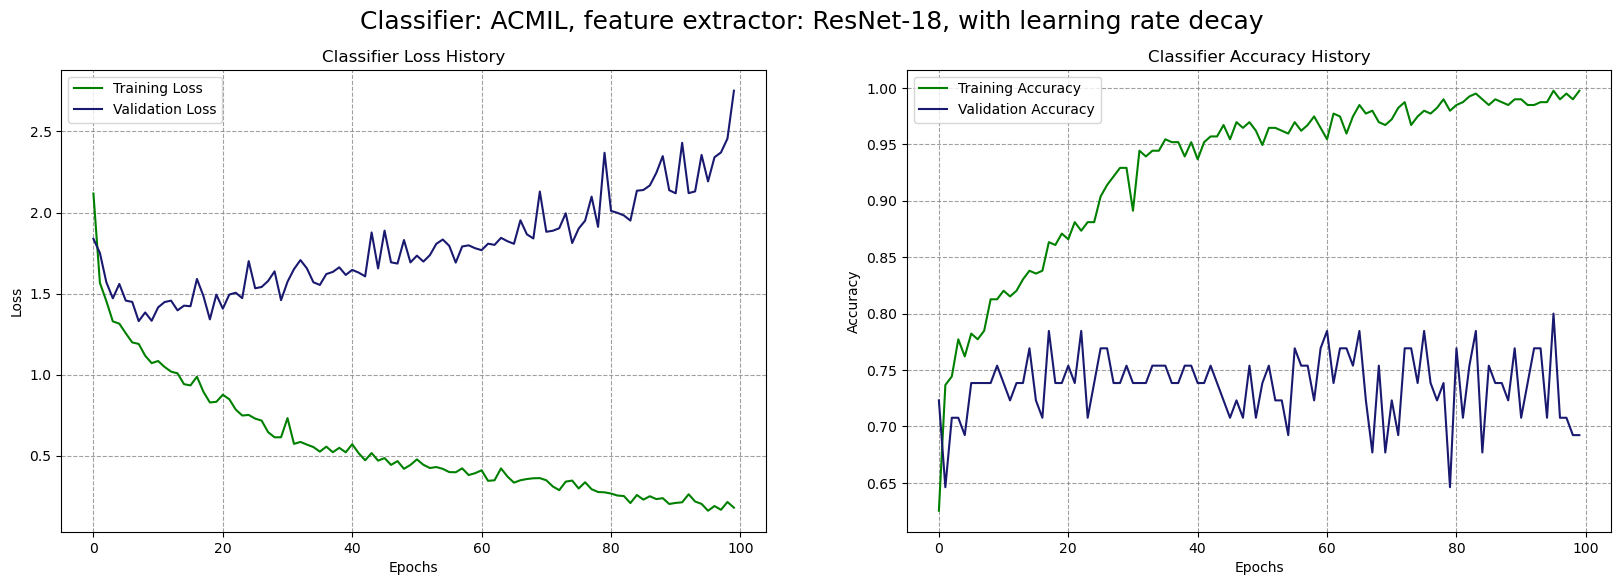

In [13]:
plot_loss_accuracy(train_history=train_his, val_history=val_his, title="Classifier: ACMIL, feature extractor: ResNet-18, with learning rate decay")

### Data Loading

In [14]:
datatset = TensorDataset(root=TEST_DIR,transform=None)
loader = DataLoader(dataset=datatset, batch_size=BATCH_SIZE, shuffle=True)

### Inference

In [15]:
def predict(
    loader : DataLoader,
    model : MultiBranchAttention
) -> tuple[torch.Tensor,torch.Tensor]:
    
    model.eval()

    Y_hat = []
    Y = []

    with torch.inference_mode():

        for x,y in tqdm(loader):

            x,y = x.to(device),y.to(device)

            y_hat = model(x)[1]

            y_hat = torch.squeeze(y_hat)

            y = torch.squeeze(y).item()

            Y.append(y)
            Y_hat.append(y_hat)
    
    Y_hat = torch.vstack(Y_hat)
    Y = torch.tensor(Y)
    Y = Y.squeeze()
    Y = Y.to(device)

    return Y_hat,Y

In [16]:
Y_hat,Y = predict(loader,model)

  0%|          | 0/87 [00:00<?, ?it/s]

In [17]:
print(Y_hat.shape,Y.shape)

torch.Size([87, 3]) torch.Size([87])


### Computing metrics

In [18]:
metrics = {
    "accuracy" : Accuracy(task='multiclass',num_classes=3).to(device),
    "f1_score" : F1Score(task='multiclass',num_classes=3,average='macro').to(device),
    "auc" : AUROC(task='multiclass',num_classes=3).to(device),
    "recall" : Recall(task='multiclass',num_classes=3,average='macro').to(device),
    "precision" : Precision(task='multiclass',num_classes=3,average='macro').to(device)
}

In [19]:
def compute_metrics(metrics : dict[str,Metric], y : torch.Tensor, y_hat : torch.Tensor) -> dict:

    result = {}

    for name, metric in metrics.items():
        score = metric(y_hat, y)
        result[name] = score.item()

    return  result

In [20]:
compute_metrics(metrics, Y, Y_hat)

{'accuracy': 0.6321839094161987,
 'f1_score': 0.48685145378112793,
 'auc': 0.7945982217788696,
 'recall': 0.5729166269302368,
 'precision': 0.430402934551239}